In [ ]:
# ============================================================
# 1. LOAD PRE-SAVED ARRAYS
# ============================================================
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
X = np.load("/content/drive/MyDrive/cremad_data_splits/spectrograms/X_2d.npy")   # (N, 128, 200, 1)
y = np.load("/content/drive/MyDrive/cremad_data_splits/spectrograms/y.npy")      # (N,)

print("X:", X.shape)
print("y:", y.shape)


Mounted at /content/drive
X: (7442, 128, 200, 1)
y: (7442,)


In [ ]:
# ============================================================
# 2. TRAIN / VALIDATION SPLIT
# ============================================================
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)


Train: (5953, 128, 200, 1)
Val: (1489, 128, 200, 1)


In [ ]:
# ============================================================
# 3. MODEL ARCHITECTURE — 2D-CNN → 2×Bi-LSTM
# ============================================================
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_bilstm_model(input_shape=(128, 200, 1), num_classes=6):

    inputs = layers.Input(shape=input_shape)

    # ---- CNN BLOCK 1 ----
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)   # (64, 100, 32)

    # ---- CNN BLOCK 2 ----
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)   # (32, 50, 64)

    # ---- CNN BLOCK 3 ----
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)   # (16, 25, 128)

    # ---- RESHAPE FOR LSTM ----
    x = layers.Reshape((25, 16*128))(x)  # (25, 2048)

    # ---- BI-LSTM LAYER 1 ----
    x = layers.Bidirectional(
        layers.LSTM(128, return_sequences=True)
    )(x)

    # ---- BI-LSTM LAYER 2 ----
    x = layers.Bidirectional(
        layers.LSTM(64)
    )(x)

    # ---- CLASSIFIER ----
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

model = build_cnn_bilstm_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 200, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 200, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 200, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 100, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 100, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 100, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 25, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 25, 256)        │     2,229,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,504,454 (9.55 MB)

 Trainable params: 2,504,006 (9.55 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def train_and_evaluate(model,
                       X_train, y_train,
                       X_val, y_val,
                       name="MyModel",
                       batch_size=16,
                       epochs=40):

    print(f"\n==============================")
    print(f" TRAINING: {name}")
    print(f"==============================\n")

    # ------------------------
    # Compile
    # ------------------------
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            patience=8, monitor='val_accuracy', restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            patience=4, factor=0.5, monitor='val_loss'
        )
    ]

    # ------------------------
    # TRAIN
    # ------------------------
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    # ------------------------
    # EVALUATE
    # ------------------------
    loss, acc = model.evaluate(X_val, y_val, verbose=1)
    print(f"\n{name} — Validation Accuracy: {acc:.4f}")
    print(f"{name} — Validation Loss: {loss:.4f}")

    # ------------------------
    # PLOTS
    # ------------------------
    plt.figure(figsize=(14,5))

    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f"{name} — Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Val"])

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f"{name} — Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Train", "Val"])

    plt.show()

    # ------------------------
    # CLASSIFICATION REPORT
    # ------------------------
    y_pred = model.predict(X_val)
    y_pred_classes = y_pred.argmax(axis=1)

    print(f"\n{name} — Classification Report:\n")
    print(classification_report(y_val, y_pred_classes))

    # ------------------------
    # CONFUSION MATRIX
    # ------------------------
    cm = confusion_matrix(y_val, y_pred_classes)

    plt.figure(figsize=(8,6))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["NEU","HAP","SAD","ANG","FEA","DIS"],
        yticklabels=["NEU","HAP","SAD","ANG","FEA","DIS"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} — Confusion Matrix")
    plt.show()

    return history, acc, loss



 TRAINING: CNN_BiLSTM_v1

373/373 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.3185 - loss: 1.6260 - val_accuracy: 0.3378 - val_loss: 1.5669 - learning_rate: 1.0000e-04
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3527 - loss: 1.5615

CNN_BiLSTM_v1 — Validation Accuracy: 0.3378
CNN_BiLSTM_v1 — Validation Loss: 1.5669


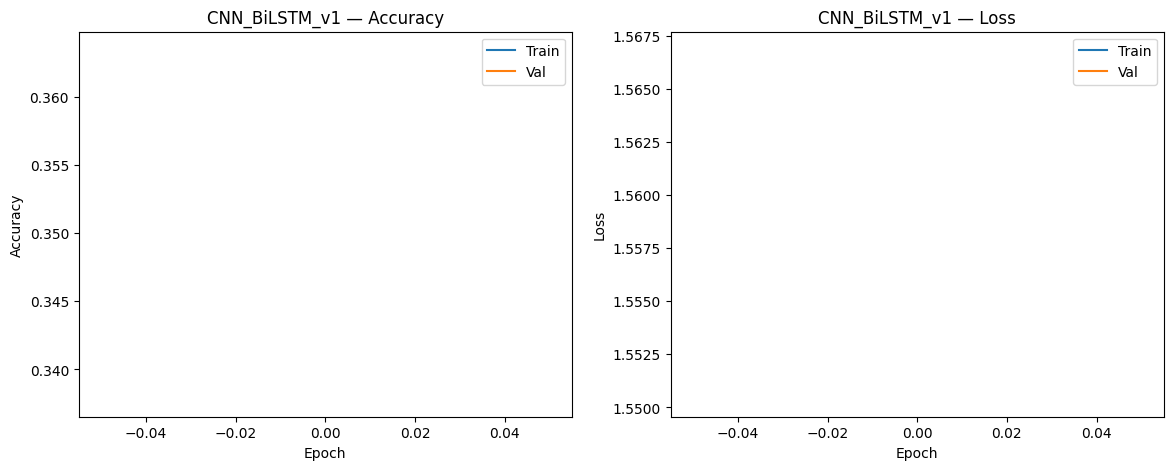

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

CNN_BiLSTM_v1 — Classification Report:

              precision    recall  f1-score   support

           0       0.26      0.59      0.36       218
           1       0.33      0.22      0.26       254
           2       0.49      0.18      0.26       254
           3       0.37      0.88      0.52       254
           4       0.60      0.01      0.02       255
           5       0.39      0.19      0.25       254

    accuracy                           0.34      1489
   macro avg       0.41      0.34      0.28      1489
weighted avg       0.41      0.34      0.28      1489



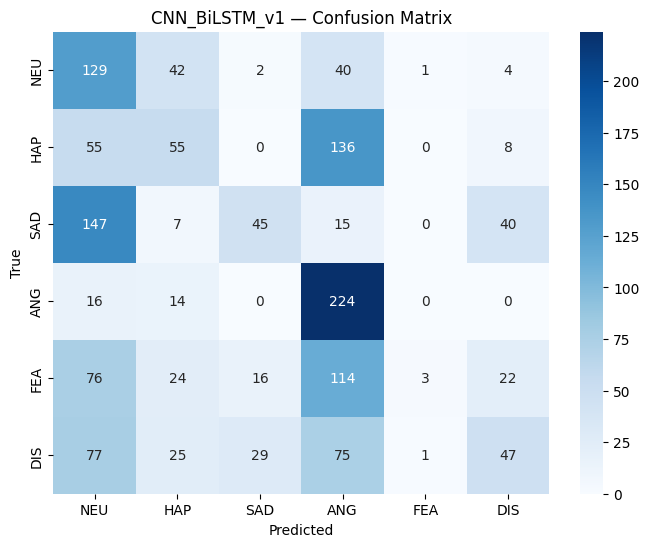

In [ ]:
model = build_cnn_bilstm_model()

history, acc, loss = train_and_evaluate(
    model,
    X_train, y_train,
    X_val, y_val,
    name="CNN_BiLSTM_v1",
    batch_size=16,
    epochs=1
)


# Lighter Test Model


In [ ]:
# ============================================================
# LIGHT 2D-CNN → Bi-LSTM MODEL
# ============================================================
import tensorflow as tf
from tensorflow.keras import layers, models

def build_light_cnn_bilstm_model(input_shape=(128, 200, 1), num_classes=6):

    inputs = layers.Input(shape=input_shape)

    # ---- CNN BLOCK 1 ----
    x = layers.Conv2D(16, (3,3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)   # (64, 100, 16)

    # ---- CNN BLOCK 2 ----
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)   # (32, 50, 32)

    # ---- CNN BLOCK 3 ----
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)   # (16, 25, 64)

    # ---- RESHAPE FOR LSTM ----
    # now feature_dim = 16 * 64 = 1024 (instead of 2048)
    x = layers.Reshape((25, 16 * 64))(x)

    # ---- BI-LSTM LAYER 1 (smaller) ----
    x = layers.Bidirectional(
        layers.LSTM(64, return_sequences=True)
    )(x)

    # ---- BI-LSTM LAYER 2 (smaller) ----
    x = layers.Bidirectional(
        layers.LSTM(32)
    )(x)

    # ---- CLASSIFIER (smaller dense) ----
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model





 TRAINING: CNN_BiLSTM_v1

Epoch 1/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.2783 - loss: 1.7043 - val_accuracy: 0.3774 - val_loss: 1.5308 - learning_rate: 1.0000e-04
Epoch 2/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.3934 - loss: 1.4955 - val_accuracy: 0.3774 - val_loss: 1.5237 - learning_rate: 1.0000e-04
Epoch 3/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.4459 - loss: 1.4078 - val_accuracy: 0.3949 - val_loss: 1.4816 - learning_rate: 1.0000e-04
Epoch 4/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.4799 - loss: 1.3310 - val_accuracy: 0.4560 - val_loss: 1.3656 - learning_rate: 1.0000e-04
Epoch 5/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.5259 - loss: 1.2517 - val_accuracy: 0.4547 - val_loss: 1.3591 - learning_rate: 1.0000e-04
Epoch 6/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5849 - loss: 1.1124 - val_accuracy: 0.4547 - val_loss: 1.3778 - learning_rate: 1.0000e-04
Epoch 7/30
373/373 ━━━━━━

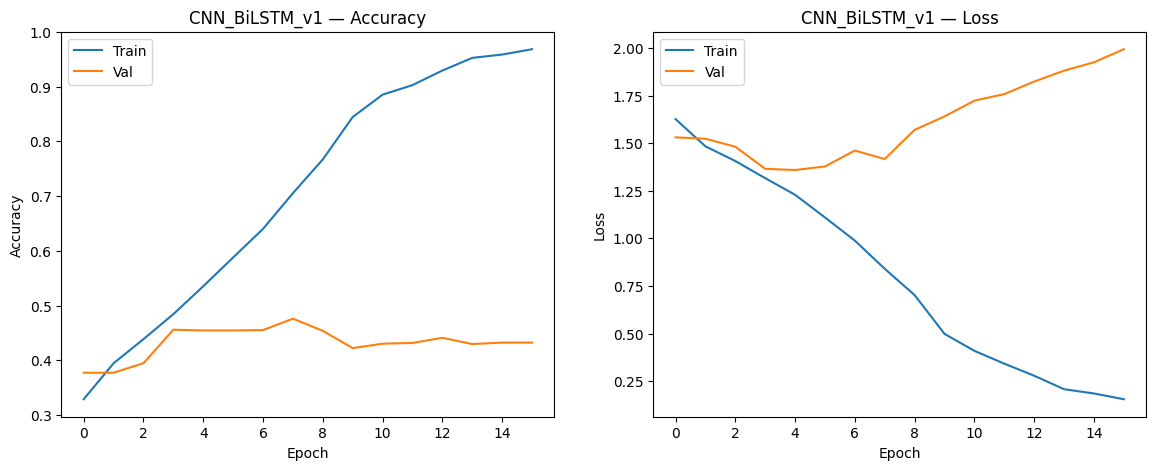

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

CNN_BiLSTM_v1 — Classification Report:

              precision    recall  f1-score   support

           0       0.44      0.47      0.46       218
           1       0.39      0.50      0.44       254
           2       0.52      0.53      0.52       254
           3       0.60      0.71      0.65       254
           4       0.39      0.31      0.35       255
           5       0.49      0.33      0.39       254

    accuracy                           0.48      1489
   macro avg       0.47      0.48      0.47      1489
weighted avg       0.47      0.48      0.47      1489



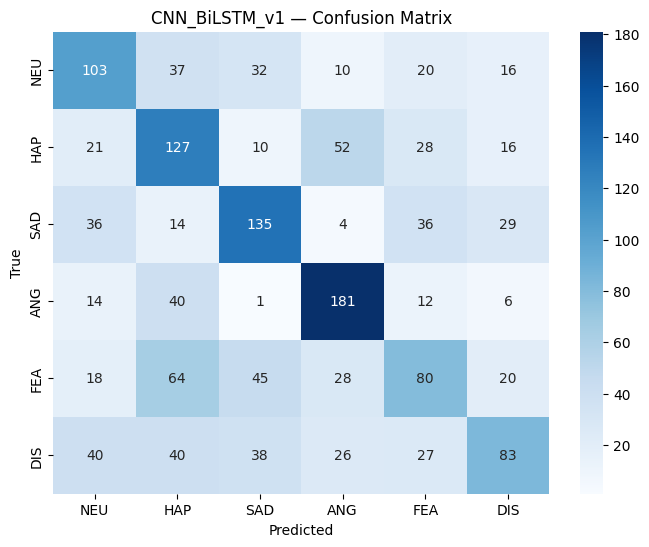

In [ ]:
lightmodel = build_light_cnn_bilstm_model()
history, acc, loss = train_and_evaluate(
    lightmodel,
    X_train, y_train,
    X_val, y_val,
    name="CNN_BiLSTM_v1",
    batch_size=16,
    epochs=30
)


# Reducing Overfitting


# Speaker Split

In [ ]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

filenames = np.load("/content/drive/MyDrive/cremad_data_splits/spectrograms/cremad_filenames.npy")

speakers = np.array([f.split('_')[0] for f in filenames])
unique_speakers = np.unique(speakers)

train_spk, val_spk = train_test_split(
    unique_speakers, test_size=0.2, random_state=42
)

train_idx = np.isin(speakers, train_spk)
val_idx = np.isin(speakers, val_spk)

X_train = X[train_idx]
X_val   = X[val_idx]
y_train = y[train_idx]
y_val   = y[val_idx]



 TRAINING: SpeakerSplit

Epoch 1/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.2626 - loss: 1.7189 - val_accuracy: 0.3653 - val_loss: 1.5295 - learning_rate: 1.0000e-04
Epoch 2/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.3883 - loss: 1.5051 - val_accuracy: 0.3789 - val_loss: 1.4888 - learning_rate: 1.0000e-04
Epoch 3/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4378 - loss: 1.4142 - val_accuracy: 0.3409 - val_loss: 1.5850 - learning_rate: 1.0000e-04
Epoch 4/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.4812 - loss: 1.3257 - val_accuracy: 0.3415 - val_loss: 1.6014 - learning_rate: 1.0000e-04
Epoch 5/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.5336 - loss: 1.2181 - val_accuracy: 0.4014 - val_loss: 1.4774 - learning_rate: 1.0000e-04
Epoch 6/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.5740 - loss: 1.1361 - val_accuracy: 0.4497 - val_loss: 1.4076 - learning_rate: 1.0000e-04
Epoch 7/30
369/369 ━━━━━━━

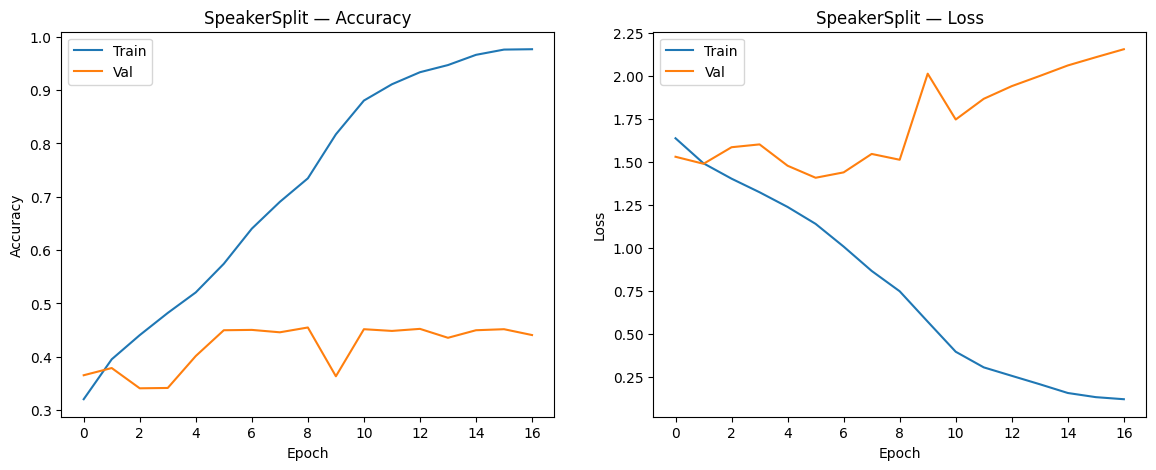

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

SpeakerSplit — Classification Report:

              precision    recall  f1-score   support

           0       0.45      0.41      0.43       227
           1       0.39      0.56      0.46       265
           2       0.41      0.60      0.49       265
           3       0.65      0.61      0.63       265
           4       0.46      0.30      0.36       265
           5       0.39      0.25      0.30       265

    accuracy                           0.45      1552
   macro avg       0.46      0.45      0.45      1552
weighted avg       0.46      0.45      0.45      1552



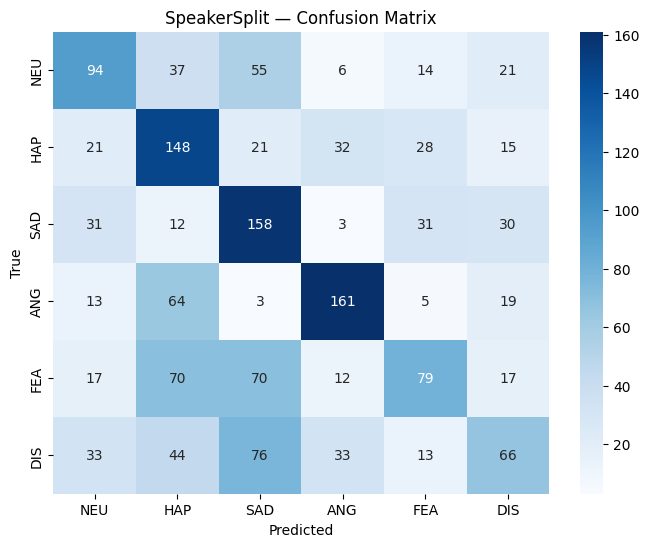

In [ ]:
lightmodel = build_light_cnn_bilstm_model()
history, acc, loss = train_and_evaluate(
    lightmodel,
    X_train, y_train,
    X_val, y_val,
    name="  SpeakerSplit",
    batch_size=16,
    epochs=30
)
